In [62]:
%matplotlib inline

import datetime
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cbook as cbook
from matplotlib.collections import PatchCollection
import matplotlib.patches as patches
from PIL import Image
import os
import pandas as pd
import numpy as np
import random
import cv2
import csv
import os, sys, time, datetime, random
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from torchvision import datasets, models
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import FasterRCNN
from skimage import io

sys.path.append('../../')
from image_size import get_image_size # source: https://github.com/scardine/image_size

In [63]:
DIR_PATH = '/Users/alexdrozdz/Desktop/Studia/00. Seminarium magisterskie/'

In [64]:
def from_tsv_to_list(path):
    tsv_file = open(path)
    read_tsv = csv.reader(tsv_file, delimiter=";")

    expected = list(read_tsv)[0]
    
    return expected

In [65]:
# train
expected_train = from_tsv_to_list(DIR_PATH + 'Master_gonito/train/expected.tsv')
in_train = from_tsv_to_list(DIR_PATH + 'Master_gonito/train/in.tsv')

# val
expected_val = from_tsv_to_list(DIR_PATH + 'Master_gonito/dev-0/expected.tsv')
in_val = from_tsv_to_list(DIR_PATH + 'Master_gonito/dev-0/in.tsv')

# test
expected_test = from_tsv_to_list(DIR_PATH + 'Master_gonito/test-A/expected.tsv')
in_test = from_tsv_to_list(DIR_PATH + 'Master_gonito/test-A/in.tsv')

In [66]:
def show_random_img_with_all_annotations(in_list, expected_list, path_to_photos, matplotlib_colours_list, pages=5):
    for page in range(pages):
        random_img = random.randint(0,len(in_list))
        file_name = in_list[random_img]
        print(file_name)

        with cbook.get_sample_data(path_to_photos + file_name) as image_file:
            image = plt.imread(image_file)

        fig, ax = plt.subplots(figsize=(15, 10))
        ax.imshow(image, cmap='gray')

        annotations = expected_list[random_img].split(' ')
        for i in range(len(annotations)):
            bbox = annotations[i].split('/')[1]
            x0 = int(bbox.split(',')[0])
            y0 = int(bbox.split(',')[1])
            width = int(bbox.split(',')[2])
            height = int(bbox.split(',')[3])
            cat_id = int(annotations[i].split('/')[0])
            rect = matplotlib.patches.Rectangle(
                (x0, y0), 
                width, 
                height, 
                linewidth=1, 
                edgecolor=matplotlib_colours_list[cat_id], 
                facecolor='none'
            )
                
            ax.add_patch(rect)           
            ax.text(
                x0, 
                y0, 
                cat_id, 
                fontsize=8,
                backgroundcolor='black',
                color=matplotlib_colours_list[cat_id]
            )

        plt.show()

2174.jpg


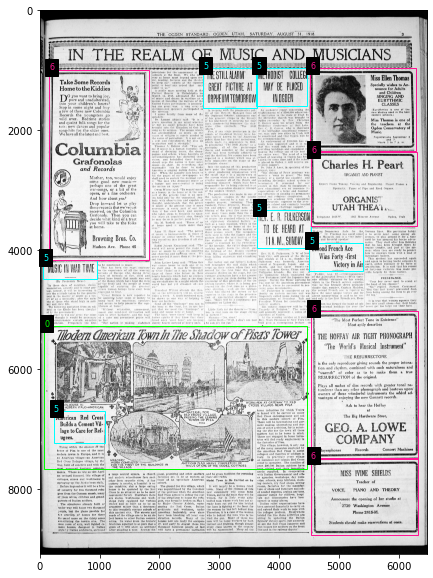

945.jpg


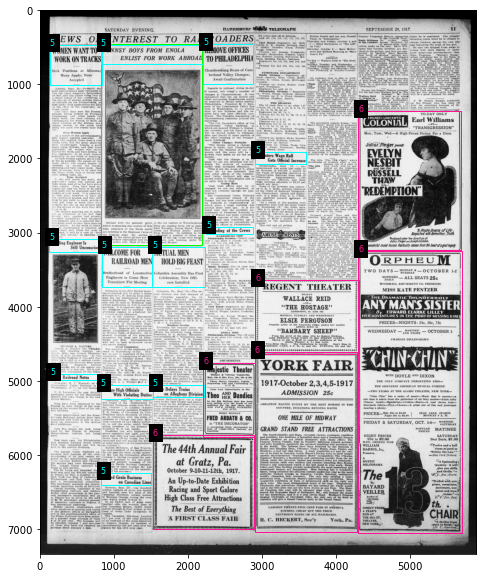

3222.jpg


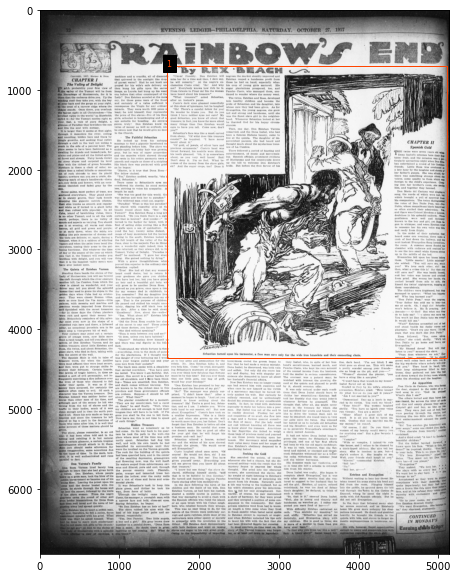

3228.jpg


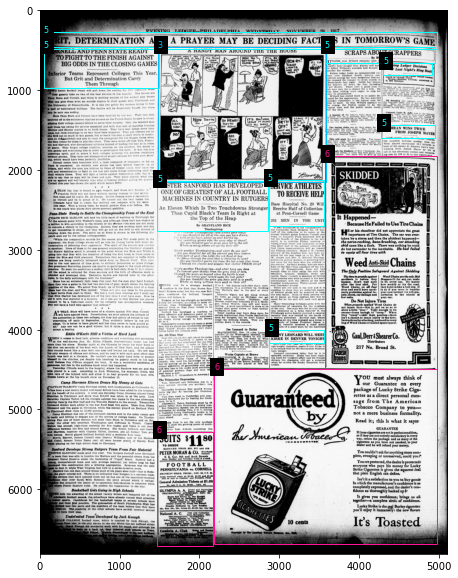

3491.jpg


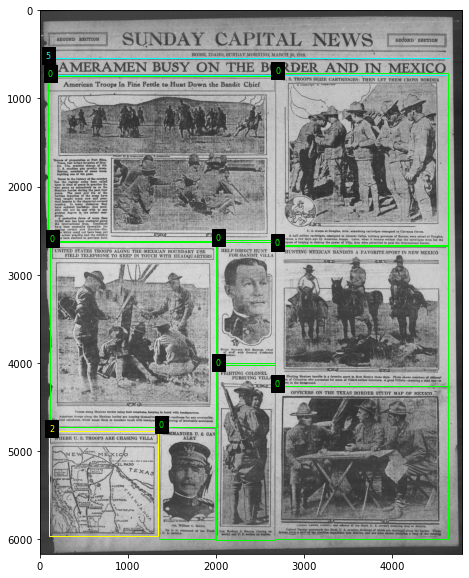

In [240]:
# some random images with annotations
show_random_img_with_all_annotations(
    in_train,
    expected_train,
    DIR_PATH+'scraped_photos_final/',
    ['lime','orangered','yellow','deepskyblue','violet','cyan','deeppink'],
    5
)

In [67]:
class NewspapersDataset(Dataset):
    def __init__(self, img_dir, in_list, expected_list, transform=None, scale=None):
        # selfs
        self.img_dir = img_dir
        self.transform = transform
        self.in_list = in_list
        self.expected_list = expected_list
        self.scale = scale
        
        # read gonito format files
        self.df = pd.DataFrame()
        for i in range(len(self.in_list)):
            if self.scale:
                img_width, img_height = get_image_size.get_image_size(
                    img_dir+self.in_list[i]
                )
                scaler_w = scale[0]/img_width
                scaler_h = scale[1]/img_height
            else:
                scaler_w, scaler_h = 1, 1
            expected_list_split = self.expected_list[i].split(' ')
            for ii in range(len(expected_list_split)):
                expected_list_split_2 = expected_list_split[ii].split('/')
                bbox = expected_list_split_2[1].split(',')
                temp_dict = {
                    'file_name': self.in_list[i],
                    'class': expected_list_split_2[0],
                    'x0': int(int(bbox[0])*scaler_w),
                    'y0': int(int(bbox[1])*scaler_h),
                    'x1': int((int(bbox[0])+int(bbox[2]))*scaler_w),
                    'y1': int((int(bbox[1])+int(bbox[3]))*scaler_h),
                }
                self.df = self.df.append(temp_dict, ignore_index=True)
    
    def __len__(self):
        return len(self.expected_list)
    
    def __getitem__(self, index):
        # read images
        img_path = os.path.join(self.img_dir, self.df.iloc[index, 0])
        image = Image.open(img_path)

        # get bbox and area
        bbox = [self.df.x0[index], self.df.y0[index], self.df.x1[index], self.df.y1[index]]
        area = (self.df.y1[index]-self.df.y0[index])*(self.df.x1[index]-self.df.x0[index])
             
        # transformation to tensors
        bbox = torch.as_tensor(bbox, dtype=torch.float32)
        area = torch.as_tensor(area, dtype=torch.float32)
        label = torch.tensor(int(self.df.iloc[index, 1]))
        
        target = {}
        target["boxes"] = bbox
        target["labels"] = label
        target["image_id"] = index+1 
        target["area"] = area
        
        # data transformation
        if self.transform:            
            image = self.transform(image)
        
        return (image, target)

In [68]:
# hyperparameters
IN_CHANNEL = 1 
NUM_CLASSES = 8 # background is also a class
LEARNING_RATE = 5e-3
BATCH_SIZE = 32
NUM_EPOCHS = 10
RESIZE = [850, 1050]

In [69]:
# load datasets
image_dir = DIR_PATH + 'scraped_photos_final/'
data_transform = transforms.Compose(
    [
        transforms.Resize(RESIZE),
        transforms.Grayscale(num_output_channels=IN_CHANNEL),
        transforms.ToTensor(),
    ]
)

train_dataloader = DataLoader(
    NewspapersDataset(
        image_dir,
        in_train, 
        expected_train,
        transform=data_transform,
        scale=RESIZE
    ),
    batch_size=BATCH_SIZE 
)

val_dataloader = DataLoader(
    NewspapersDataset(
        image_dir,
        in_val, 
        expected_val,
        transform=data_transform,
        scale=RESIZE
    ),
    batch_size=BATCH_SIZE 
)

test_dataloader = DataLoader(
    NewspapersDataset(
        image_dir,
        in_test, 
        expected_test,
        transform=data_transform,
        scale=RESIZE
    ),
    batch_size=BATCH_SIZE 
)

In [70]:
# pre-trained model
resnet50 = torchvision.models.detection.fasterrcnn_resnet50_fpn(
    pretrained=True
)

resnet50.out_channels = 1280

In [71]:
# freeze layers (gradient will not be calculated during backpropagation)
for param in resnet50.parameters():
    param.requires_grad = False

In [72]:
# we need to change the predictor layers to match the number of classes in our custom dataset
resnet50.roi_heads.box_predictor.cls_score = nn.Linear(1024, out_features=NUM_CLASSES) 
resnet50.roi_heads.box_predictor.bbox_pred = nn.Linear(1024, out_features=NUM_CLASSES*4)

In [73]:
resnet50.roi_heads.box_predictor

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=8, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=32, bias=True)
)

In [74]:
# the optimizer needs to be modified (because of frozen parameters) to only get the parameters with requires_grad=True
optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, resnet50.parameters()), 
    lr=LEARNING_RATE
)

In [75]:
# learning rate scheduler decreases the learning rate by 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

In [76]:
# main model
model = FasterRCNN(
    resnet50,
    num_classes=NUM_CLASSES,
)

In [77]:
# switch to gpu if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [78]:
# move model to the right device
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): FasterRCNN(
    (transform): GeneralizedRCNNTransform(
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        Resize(min_size=(800,), max_size=1333, mode='bilinear')
    )
    (backbone): BackboneWithFPN(
      (body): IntermediateLayerGetter(
        (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (relu): ReLU(inplace=True)
        (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (layer1): Sequential(
          (0): Bottleneck(
            (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn1): FrozenBatchNorm2d(64, eps=0.0)
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 

In [79]:
# for data, labels in tqdm(train_dataloader):
#     print(data, labels)
#     break

In [81]:
for epoch in range(NUM_EPOCHS):
    train_loss = 0.0
    for image, target in tqdm(train_dataloader):
        data = train_dataloader["image"].float().to(device)
        labels = train_dataloader["labels"].float().to(device)
        
        # clear the gradients
        optimizer.zero_grad()
        # forward pass
        target = model(image, labels)
        # find the loss
        loss = F.cross_entropy(target, labels)
        # calculate gradients 
        loss.backward()
        # update weights
        optimizer.step()
        # calculate loss
        train_loss += loss.item()
    
    print(f'{datetime.datetime.now()} - epoch {epoch+1}: loss = {train_loss / len(train_dataloader)}')
    
    lr_scheduler.step()

  0%|          | 0/83 [00:09<?, ?it/s]


TypeError: 'DataLoader' object is not subscriptable

In [ ]:
def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):
        loss_train = 0.0

        for imgs, labels in train_loader:
            outputs = model(imgs)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loss_train += loss.item()

        if epoch == 1 or epoch % 10 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))

In [42]:
# train and val loop
model.train()
num_epochs = 1
for epoch in tqdm(range(num_epochs)):
    for images, labels in iter(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()
        
    test_error_count = 0.0
    for images, labels in iter(val_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        test_error_count += float(torch.sum(torch.abs(labels - outputs.argmax(1))))
    
    test_accuracy = 1.0 - float(test_error_count) / float(len(expected_val))
    print('%d: %f' % (epoch, test_accuracy))

  0%|          | 0/1 [00:09<?, ?it/s]


AttributeError: 'dict' object has no attribute 'to'